# House price prediction (scikit pipelines)

## Imports and configuration

In [370]:
# Let's get the relevant modules
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

# Mute warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [371]:
# function to load dataset
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

# Clean Data

data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df.Exterior2nd.unique()

# comparing these to data_description.txt shows us what needs cleaning. 
# We'll take care of a couple of issues here, but you might want to evaluate 
# this data further.

def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


# Encode the Statistical Data Type

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", 
                "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


# get preprocessed data
house_train, house_test = load_data()

### Variable types

In [345]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1201 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             91 non-null     category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1442 n

In [346]:
cols_categorical = house_train.select_dtypes("category").shape[1]; cols_numeric = house_train.select_dtypes(exclude = "category").shape[1]
cols_categorical_test = house_test.select_dtypes("category").shape[1]; cols_numeric_test = house_test.select_dtypes(exclude = "category").shape[1]

print(f"There are {cols_categorical} categorical and {cols_numeric} numeric variables in the training dataset")
print(f"There are {cols_categorical_test} categorical and {cols_numeric_test} numeric variables in the test dataset")

There are 46 categorical and 34 numeric variables in the training dataset
There are 46 categorical and 34 numeric variables in the test dataset


### Examine missing amount in dataset

In [347]:
print('Feature | % of null values\n')
for feature in house_train.columns:
    print(f'{feature:>12}: {round(house_train[feature].isna().sum()/len(house_train), 3):>.2%}')

Feature | % of null values

  MSSubClass: 0.00%
    MSZoning: 0.00%
 LotFrontage: 17.70%
     LotArea: 0.00%
      Street: 0.00%
       Alley: 93.80%
    LotShape: 0.00%
 LandContour: 0.00%
   Utilities: 0.00%
   LotConfig: 0.00%
   LandSlope: 0.00%
Neighborhood: 0.00%
  Condition1: 0.00%
  Condition2: 0.00%
    BldgType: 0.00%
  HouseStyle: 0.00%
 OverallQual: 1.20%
 OverallCond: 0.00%
   YearBuilt: 0.00%
YearRemodAdd: 0.00%
   RoofStyle: 0.00%
    RoofMatl: 0.00%
 Exterior1st: 0.00%
 Exterior2nd: 0.00%
  MasVnrType: 0.50%
  MasVnrArea: 0.50%
   ExterQual: 0.00%
   ExterCond: 0.00%
  Foundation: 0.00%
    BsmtQual: 2.50%
    BsmtCond: 2.50%
BsmtExposure: 2.60%
BsmtFinType1: 2.50%
  BsmtFinSF1: 0.00%
BsmtFinType2: 2.60%
  BsmtFinSF2: 0.00%
   BsmtUnfSF: 0.00%
 TotalBsmtSF: 0.00%
     Heating: 0.00%
   HeatingQC: 0.00%
  CentralAir: 0.00%
  Electrical: 0.10%
  FirstFlrSF: 0.00%
 SecondFlrSF: 0.00%
LowQualFinSF: 0.00%
   GrLivArea: 0.00%
BsmtFullBath: 0.00%
BsmtHalfBath: 0.00%
    FullBa

There are 5 variables that have more 40% of the data missing. These should be removed from the dataset. This will be done twoards the end, during data split.

In [349]:
# check missing again
print('Feature | % of null values\n')
for feature in house_train.columns:
    print(f'{feature:>12}: {round(house_train[feature].isna().sum()/len(house_train), 3):>.2%}')

Feature | % of null values

  MSSubClass: 0.00%
    MSZoning: 0.00%
 LotFrontage: 17.70%
     LotArea: 0.00%
      Street: 0.00%
    LotShape: 0.00%
 LandContour: 0.00%
   Utilities: 0.00%
   LotConfig: 0.00%
   LandSlope: 0.00%
Neighborhood: 0.00%
  Condition1: 0.00%
  Condition2: 0.00%
    BldgType: 0.00%
  HouseStyle: 0.00%
 OverallQual: 1.20%
 OverallCond: 0.00%
   YearBuilt: 0.00%
YearRemodAdd: 0.00%
   RoofStyle: 0.00%
    RoofMatl: 0.00%
 Exterior1st: 0.00%
 Exterior2nd: 0.00%
  MasVnrType: 0.50%
  MasVnrArea: 0.50%
   ExterQual: 0.00%
   ExterCond: 0.00%
  Foundation: 0.00%
    BsmtQual: 2.50%
    BsmtCond: 2.50%
BsmtExposure: 2.60%
BsmtFinType1: 2.50%
  BsmtFinSF1: 0.00%
BsmtFinType2: 2.60%
  BsmtFinSF2: 0.00%
   BsmtUnfSF: 0.00%
 TotalBsmtSF: 0.00%
     Heating: 0.00%
   HeatingQC: 0.00%
  CentralAir: 0.00%
  Electrical: 0.10%
  FirstFlrSF: 0.00%
 SecondFlrSF: 0.00%
LowQualFinSF: 0.00%
   GrLivArea: 0.00%
BsmtFullBath: 0.00%
BsmtHalfBath: 0.00%
    FullBath: 0.00%
    HalfBat

## Outcome examination

### Explore and handle outliers

Text(0.5, 0.98, 'The distribution of outcome with outliers')

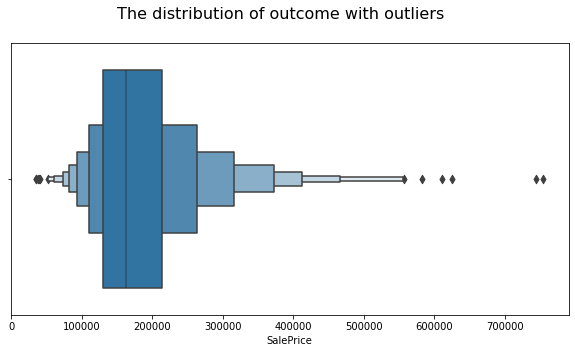

In [350]:
# plot 1) The disrtibution of the outcome variables with outliers
n = 1
plt.figure(figsize=(10,5));  sns.boxenplot(house_train['SalePrice'])
plt.suptitle("The distribution of outcome with outliers", size=16)
# plt.tight_layout()


To detect outliers in Sale price, we will plot the sale price against the GrLivArea (Above grade (ground) living area square feet) feature. We will then delete any observations that may be implausible.

Text(0.5, 0, 'GrLivArea')

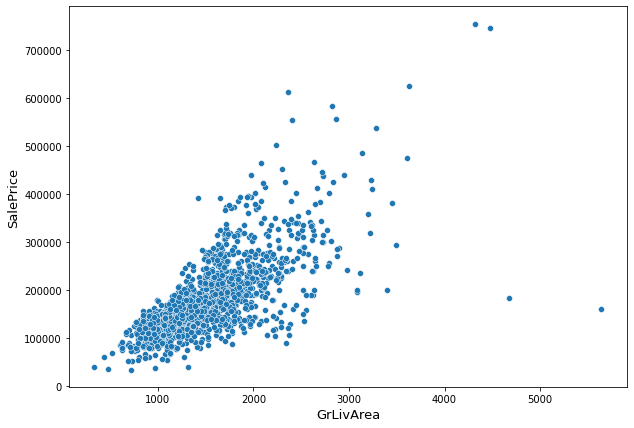

In [351]:
# plot sale price againts living area square space
plt.figure(figsize=(10,7)); sns.scatterplot(x = house_train['GrLivArea'], y = house_train['SalePrice'])
# label plot 
plt.ylabel('SalePrice', fontsize=13); plt.xlabel('GrLivArea', fontsize=13)

Here we remove houses that have a living area of more than 4000 sqaure feet but cost less than \\$300,000. This is implausible.

In [352]:
# deleting outliers that dont make sense
house_train = house_train.drop(house_train[(house_train['GrLivArea']>4000) & (house_train['SalePrice']<300000)].index)


Text(0.5, 0, 'GrLivArea')

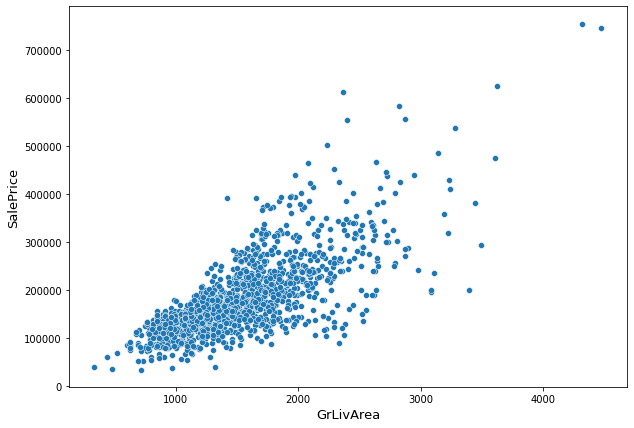

In [353]:
# plot sale price againts living area square space
plt.figure(figsize=(10,7)); sns.scatterplot(x = house_train['GrLivArea'], y = house_train['SalePrice'])
# label plot 
plt.ylabel('SalePrice', fontsize=13); plt.xlabel('GrLivArea', fontsize=13)

In [354]:
house_train.shape

(1458, 75)

### Let's examine and resolve the distribution of outcome

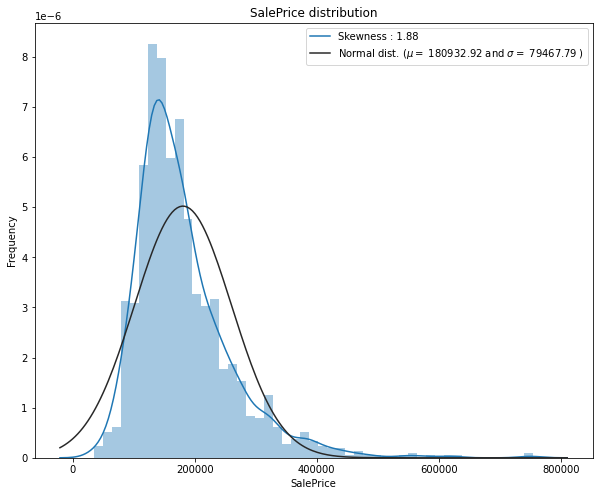

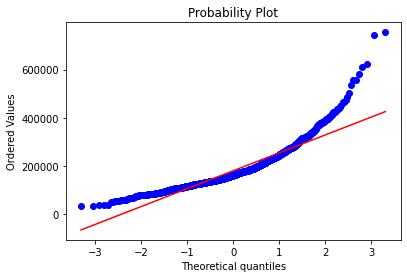

In [355]:
from scipy.stats import norm, skew, probplot # for stats

plt.figure(figsize=(10, 8)); sns.distplot(house_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(house_train['SalePrice'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Skewness : {:.2f}'.format(house_train['SalePrice'].skew()),
             'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.ylabel('Frequency'); plt.title('SalePrice distribution')

# check qqplot too
fig = plt.figure()
res = probplot(house_train['SalePrice'], plot=plt)
plt.show()

Our target variable is SalePrice. The mean is \\$ 180,932 and the standard deviation is $79,467. With a skewness of 1.88, our target variable is skewed to the right. Given that regression models perform better on normalised dataset, we will need to transform our target variable.

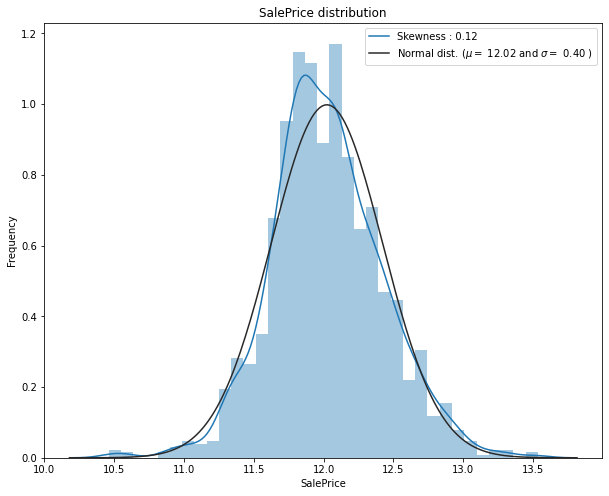

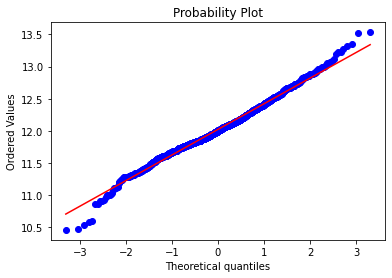

In [356]:
# lets log transform out outcome 
house_train["SalePrice"] = np.log1p(house_train["SalePrice"])

# lets replot or distribution
plt.figure(figsize=(10, 8)); sns.distplot(house_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(house_train['SalePrice'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Skewness : {:.2f}'.format(house_train['SalePrice'].skew()),
             'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
# label plot
plt.ylabel('Frequency'); plt.title('SalePrice distribution')

# check qqplot too
fig = plt.figure()
res = probplot(house_train['SalePrice'], plot=plt)
plt.show()

In [357]:
house_train.select_dtypes(exclude="object").drop(columns=["SalePrice"]).shape

(1458, 74)

<AxesSubplot:xlabel='SalePrice'>

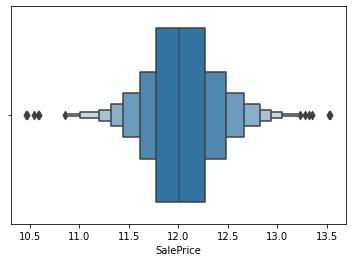

In [358]:
  sns.boxenplot(house_train['SalePrice'])

### Examine distribution of features

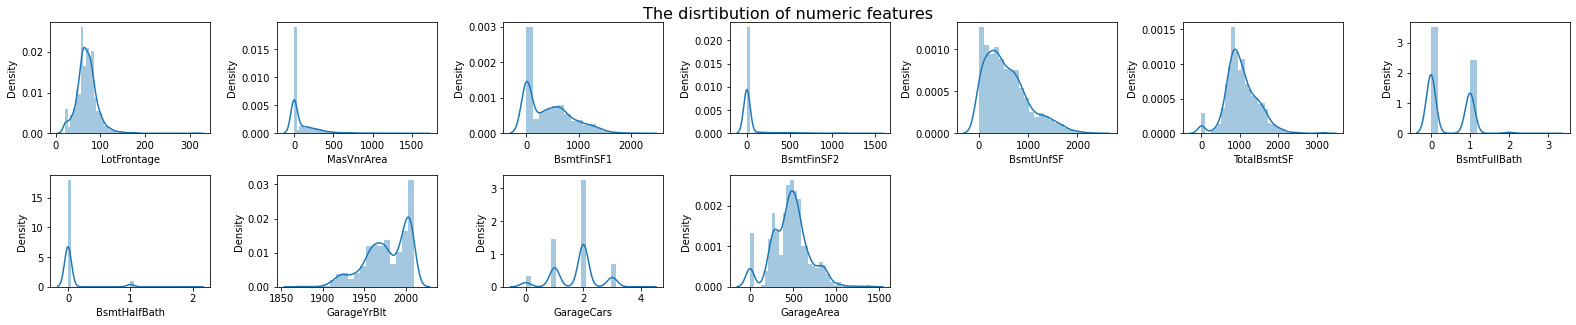

In [359]:
cols = house_train.select_dtypes(include="float").drop(columns=["SalePrice"]).columns

# plot 1) The disrtibution of numeric variables with outliers
n = 1
plt.figure(figsize=(22,15))
for column in cols:
  plt.subplot(7, 7, n)
  n = n+1
  sns.distplot(house_train[column])
  plt.suptitle("The disrtibution of numeric features", size=16)
  plt.tight_layout()

From this, it is clear that we need to scale the features as they are all in different scales, as well as transform them as some of them are skewed. These steps will be done in the pipeline.

<Figure size 1440x1152 with 0 Axes>

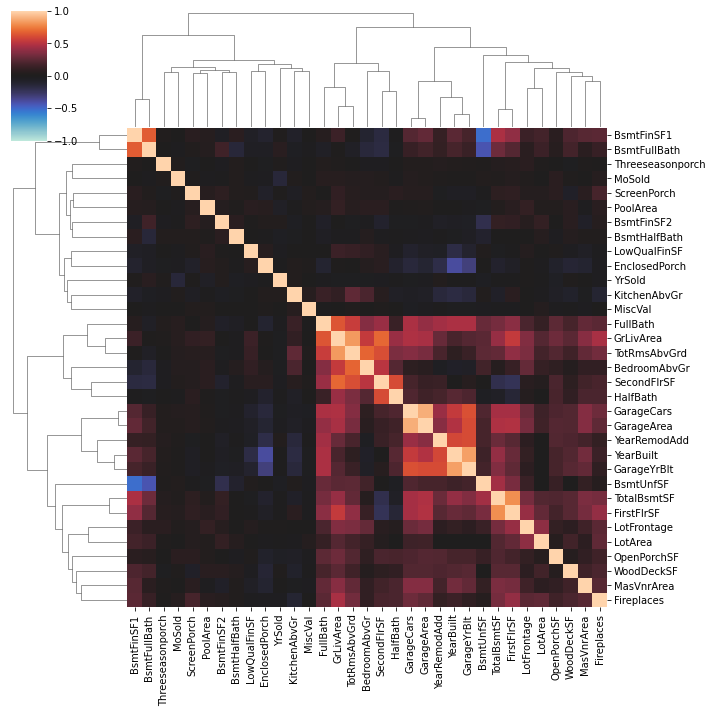

In [360]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    plt.figure(figsize=(20,16))
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(house_train.drop(columns = ["SalePrice"]), 
         annot=None)

We will create a feature utility metric, a function measuring associations between a feature and the target. We can then can choose a smaller set of the most useful features to develop initially and potentially prevent overfitting of the model.Mutual information  will be out metric, it It is very useful as it can detect any relationships, including nonlinear ones. 

### Examine best features

In [374]:

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
              ordered_levels.items()}
    
    
def make_mi_scores(df):
    
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
        
    X_train2 = house_train.drop(columns = ["SalePrice"], axis = 1)
    y_train2 = house_train["SalePrice"]

    X = X_train2.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X_train2[colname], _ = X_train2[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X_train2.dtypes]
    mi_scores = mutual_info_regression(X_train2, y_train2, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train2.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

make_mi_scores(house_train)

(     MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 Id                                                                     
 1            60       RL         65.0     8450   Pave  None      Reg   
 2            20       RL         80.0     9600   Pave  None      Reg   
 3            60       RL         68.0    11250   Pave  None      IR1   
 4            70       RL         60.0     9550   Pave  None      IR1   
 5            60       RL         84.0    14260   Pave  None      IR1   
 ...         ...      ...          ...      ...    ...   ...      ...   
 1456         60       RL         62.0     7917   Pave  None      Reg   
 1457         20       RL         85.0    13175   Pave  None      Reg   
 1458         70       RL         66.0     9042   Pave  None      Reg   
 1459         20       RL         68.0     9717   Pave  None      Reg   
 1460         20       RL         75.0     9937   Pave  None      Reg   
 
      LandContour Utilities LotConfig  ... Screen

### Split the data

In [324]:
# Train set ------------------------------

# Remove vars with 40% or more missing data.
house_train.drop(columns = ["PoolQC", "MiscFeature", "Fence", "FireplaceQu", "Alley"], inplace=True)

# make datasets for features and outcome; # drop variables with high mising rate; drop cols with missing rows
X_train = house_train.drop(columns = ["SalePrice"], axis = 1)
y_train = house_train["SalePrice"]

# Test set ------------------------------
# drop variables with high mising rate; drop cols with missing rows
X_test = house_test.drop(columns = ["PoolQC", "MiscFeature", "Fence", "FireplaceQu", "Alley"], axis = 1)

# Create column selector based on data types ----------
# select numeric features
numeric_features = house_train.drop(["SalePrice"], axis=1).select_dtypes(include = ['float64', 'int64']).columns
# categorical features
categorical_features = house_train.select_dtypes(exclude = ['float64', 'int64']).columns

In [291]:
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]
# del features_nom[]
# features_nom.remove(["PoolQC","MiscFeature", "Fence", "FireplaceQu", "Alley"])
# features_nom.remove('Alley'); features_nom.remove('MiscFeature')


In [375]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

    
make_mi_scores(X_train, y_train,)

OverallQual     0.573500
Neighborhood    0.529792
GrLivArea       0.434658
YearBuilt       0.409382
LotArea         0.400411
                  ...   
PoolArea        0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Street          0.000000
Name: MI Scores, Length: 74, dtype: float64

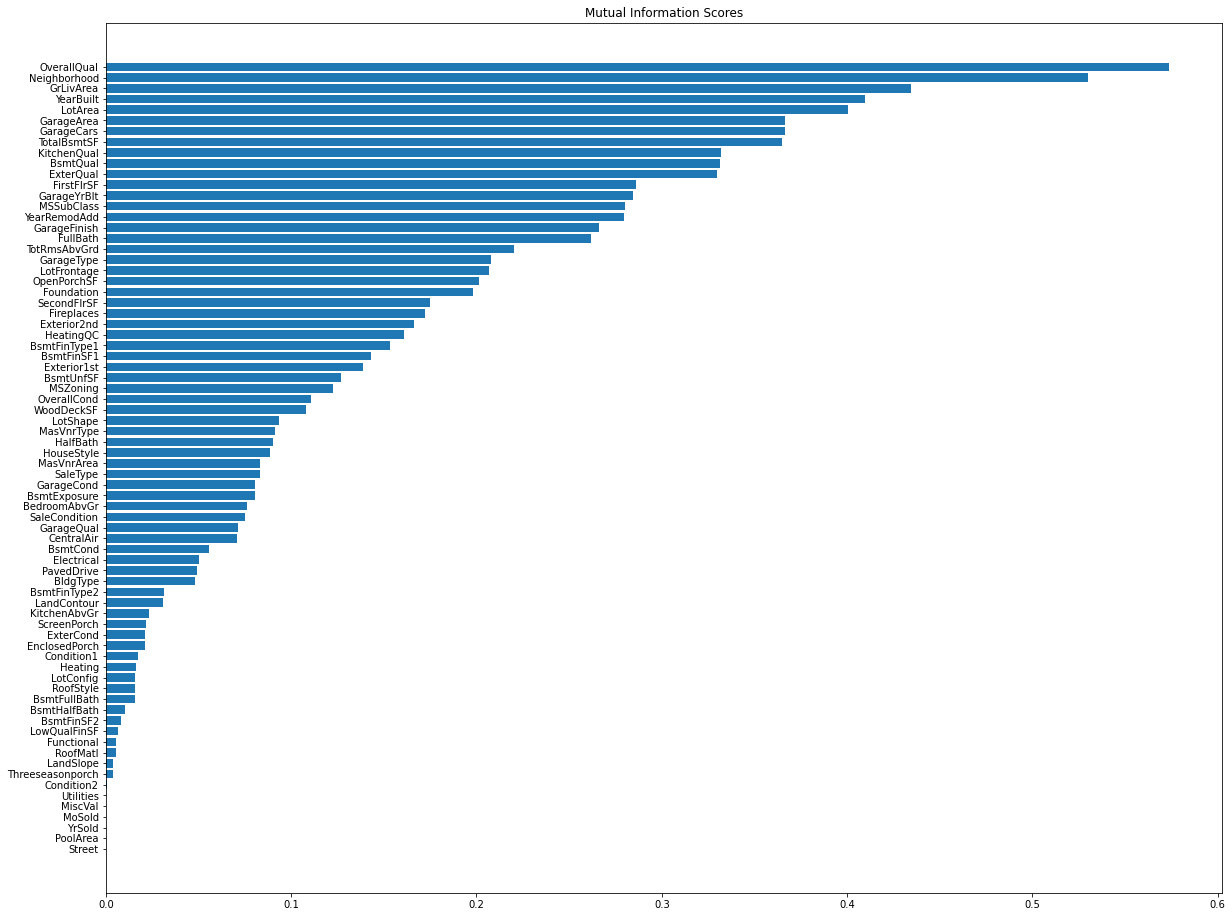

In [382]:
scores = make_mi_scores(X_train, y_train,)
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index) 
    plt.figure(figsize=(20,16))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plot_mi_scores(scores)

In [407]:
X_train[cols]

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
Id,,,,,,,,,,,
1,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0
2,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0
3,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0
4,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0
5,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0
...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,0.0,0.0,0.0,953.0,953.0,0.0,0.0,1999.0,2.0,460.0
1457,85.0,119.0,790.0,163.0,589.0,1542.0,1.0,0.0,1978.0,2.0,500.0
1458,66.0,0.0,275.0,0.0,877.0,1152.0,0.0,0.0,1941.0,1.0,252.0


In [406]:
def drop_uninformative(df, scores):
    df = pd.DataFrame(scores)
    cols = df[df['MI Scores'] > 0.0].index
    return df[cols]
    
drop_uninformative(X_train, scores).shape

KeyError: "None of [Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'LotArea',\n       'GarageArea', 'GarageCars', 'TotalBsmtSF', 'KitchenQual', 'BsmtQual',\n       'ExterQual', 'FirstFlrSF', 'GarageYrBlt', 'MSSubClass', 'YearRemodAdd',\n       'GarageFinish', 'FullBath', 'TotRmsAbvGrd', 'GarageType', 'LotFrontage',\n       'OpenPorchSF', 'Foundation', 'SecondFlrSF', 'Fireplaces', 'Exterior2nd',\n       'HeatingQC', 'BsmtFinType1', 'BsmtFinSF1', 'Exterior1st', 'BsmtUnfSF',\n       'MSZoning', 'OverallCond', 'WoodDeckSF', 'LotShape', 'MasVnrType',\n       'HalfBath', 'HouseStyle', 'MasVnrArea', 'SaleType', 'GarageCond',\n       'BsmtExposure', 'BedroomAbvGr', 'SaleCondition', 'GarageQual',\n       'CentralAir', 'BsmtCond', 'Electrical', 'PavedDrive', 'BldgType',\n       'BsmtFinType2', 'LandContour', 'KitchenAbvGr', 'ScreenPorch',\n       'ExterCond', 'EnclosedPorch', 'Condition1', 'Heating', 'LotConfig',\n       'RoofStyle', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2',\n       'LowQualFinSF', 'Functional', 'RoofMatl', 'LandSlope',\n       'Threeseasonporch', 'Condition2', 'Utilities'],\n      dtype='object')] are in the [columns]"

In [388]:
drop_uninformative(X_train, scores).info()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

### Column transformer

In [240]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Set up pipelines fo numeric and categorical vars
numeric_pipeline = Pipeline([('imp_con', IterativeImputer(estimator=BayesianRidge(), random_state=545, skip_complete=True)),
                             ('scale', RobustScaler()),
                            ('transform', QuantileTransformer(output_distribution='normal'))])

categorical_pipeline = Pipeline([('imp_cons', SimpleImputer(strategy="constant")),
                                 ('onehot', LabelEncoder())])

# set up the transformer with numerica and categorical pipelines
preprocessor = ColumnTransformer([
    ('numeric_preprocessing', numeric_pipeline, numeric_features),
    ('categorical_preprocessing', categorical_pipeline, categorical_features)])

# create preprocess column transformer to combine the numeric pipelines
ml_pipeline = Pipeline([('all_column_preprocessing', preprocessor),
                        ('model', RandomForestRegressor())])

### Examine your pipeline configuration 

In [ ]:
from sklearn import set_config

set_config(display='diagram')
display(ml_pipeline)

In [241]:
# models
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb



# for model evaluation
from sklearn.model_selection import cross_validate

# specify the metrics you want to use for evaluation
metrics = ['neg_root_mean_squared_error', 'r2']

# Lasso
ml_pipeline.steps[1] = ('model', Lasso(alpha =0.0005, random_state=1)) # update model in pipeline
scores_lasso = cross_validate(ml_pipeline, 
                            X_train, y_train, 
                            cv=5, scoring=metrics)

# Elastic
ml_pipeline.steps[1] = ('model', ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)) # update model in pipeline
scores_elastic = cross_validate(ml_pipeline, 
                            X_train, y_train, 
                            cv=5, scoring=metrics)

# Kernel ridge
ml_pipeline.steps[1] = ('model', KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)) # update model in pipeline
scores_kernel = cross_validate(ml_pipeline, 
                            X_train, y_train, 
                            cv=5, scoring=metrics)

# # light gradient boost
# ml_pipeline.steps[1] = ('model', lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)) # update model in pipeline
# scores_LGGoost = cross_validate(ml_pipeline, 
#                             X_train, y_train, 
#                             cv=5, scoring=metrics)

# # gradient boost
# ml_pipeline.steps[1] = ('model', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)) # update model in pipeline
# scores_GBoost = cross_validate(ml_pipeline, 
#                             X_train, y_train, 
#                             cv=5, scoring=metrics)

# Gradient boosted trees
ml_pipeline.steps[1] = ('model', xgb.XGBRegressor(objective="reg:squarederror", random_state=42)) # update model in pipeline
scores_xgb = cross_validate(ml_pipeline, 
                            X_train, y_train, 
                            cv=5, scoring=metrics)


print(f"On average, our Lasso regressor makes an error of {scores_lasso['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_lasso['test_neg_root_mean_squared_error'].std():.3f}$); {scores_lasso['test_r2'].mean()*100:.1f}% (+/- {scores_lasso['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"On average, our Elastic regressor makes an error of {scores_elastic['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_elastic['test_neg_root_mean_squared_error'].std():.3f}$); {scores_elastic['test_r2'].mean()*100:.1f}% (+/- {scores_elastic['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"On average, our Kernel Ridge regressor makes an error of {scores_kernel['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_kernel['test_neg_root_mean_squared_error'].std():.3f}$); {scores_kernel['test_r2'].mean()*100:.1f}% (+/- {scores_kernel['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
# print(f"On average, our LGB regressor makes an error of {scores_LGGoost['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_LGGoost['test_neg_root_mean_squared_error'].std():.3f}$); {scores_LGGoost['test_r2'].mean()*100:.1f}% (+/- {scores_LGGoost['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
# print(f"On average, our GB regressor makes an error of {scores_GBoost['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_GBoost['test_neg_root_mean_squared_error'].std():.3f}$); {scores_GBoost['test_r2'].mean()*100:.1f}% (+/- {scores_GBoost['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"On average, our XGB regressor makes an error of {scores_xgb['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_xgb['test_neg_root_mean_squared_error'].std():.3f}$); {scores_xgb['test_r2'].mean()*100:.1f}% (+/- {scores_xgb['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")

On average, our Lasso regressor makes an error of nan$ (+/- nan$); nan% (+/- nan%) of the variance in sale price has been explained by the features in the model.
On average, our Elastic regressor makes an error of nan$ (+/- nan$); nan% (+/- nan%) of the variance in sale price has been explained by the features in the model.
On average, our Kernel Ridge regressor makes an error of nan$ (+/- nan$); nan% (+/- nan%) of the variance in sale price has been explained by the features in the model.
On average, our XGB regressor makes an error of nan$ (+/- nan$); nan% (+/- nan%) of the variance in sale price has been explained by the features in the model.


In [ ]:
On average, our Lasso regressor makes an error of -0.01437$ (+/- 0.001$); 77.8% (+/- 0.03%) of the variance in sale price has been explained by the features in the model.
On average, our Elastic regressor makes an error of -0.01435$ (+/- 0.001$); 77.8% (+/- 0.03%) of the variance in sale price has been explained by the features in the model.
On average, our Kernel Ridge regressor makes an error of -0.03916$ (+/- 0.021$); -119.6% (+/- 2.02%) of the variance in sale price has been explained by the features in the model.
On average, our XGB regressor makes an error of -0.01404$ (+/- 0.001$); 78.9% (+/- 0.02%) of the variance in sale price has been explained by the features in the model.

In [ ]:
# Gradient boosted trees
ml_pipeline.steps[1] = ('model', xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                                  learning_rate=0.05, max_depth=3, 
                                                  min_child_weight=1.7817, n_estimators=2200,
                                                  reg_alpha=0.4640, reg_lambda=0.8571,
                                                  subsample=0.5213, silent=1,
                                                  random_state =7, nthread = -1)) # update model in pipeline
scores_xgb = cross_validate(ml_pipeline, 
                            X_train, y_train, 
                            cv=5, scoring=metrics)


In [ ]:
print(f"On average, our XGB regressor makes an error of {scores_xgb['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_xgb['test_neg_root_mean_squared_error'].std():.3f}$); {scores_xgb['test_r2'].mean()*100:.1f}% (+/- {scores_xgb['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")

In [ ]:
On average, our XGB regressor makes an error of -0.13947$ (+/- 0.010$); 87.7% (+/- 0.01%) of the variance in sale price has been explained by the features in the model.
On average, our XGB regressor makes an error of -29359.55413$ (+/- 4092.423$); 86.1% (+/- 0.03%) of the variance in sale price has been explained by the features in the model.
On average, our XGB regressor makes an error of -0.00133$ (+/- 0.000$); 87.6% (+/- 0.01%) of the variance in sale price has been explained by the features in the model.

In [ ]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

In [ ]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

### Build models 

In [ ]:
# models
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

# for model evaluation
from sklearn.model_selection import cross_validate

# specify the metrics you want to use for evaluation
metrics = ['neg_root_mean_squared_error', 'r2']

# Cross validate models ------------------------
# Random forest
ml_pipeline.steps[1] = ('model', RandomForestRegressor()) # update model in pipeline
scores_rf = cross_validate(ml_pipeline, 
                            X_train, y_train_log, 
                            cv=5, scoring=metrics)

# Gradient boosted trees
ml_pipeline.steps[1] = ('model', xgb.XGBRegressor(objective="reg:squarederror", random_state=42)) # update model in pipeline
scores_xgb = cross_validate(ml_pipeline, 
                            X_train, y_train_log, 
                            cv=5, scoring=metrics)

# K nearest neighbour
ml_pipeline.steps[1] = ('model', KNeighborsRegressor(algorithm="auto")) # update model in pipeline
scores_knn = cross_validate(ml_pipeline, 
                            X_train, y_train_log, 
                            cv=5, scoring=metrics)

# Stochastic Gradient Descent
ml_pipeline.steps[1] = ('model', SGDRegressor() )# update model in pipeline
scores_sgdr = cross_validate(ml_pipeline, 
                            X_train, y_train_log, 
                            cv=5, scoring=metrics)

### Evaluate model scores


In [ ]:
print(f"On average, our Random Forest regressor makes an error of {scores_rf['test_neg_root_mean_squared_error'].mean():.2f}$ (+/- {scores_rf['test_neg_root_mean_squared_error'].std():.2f}$); {scores_rf['test_r2'].mean()*100:.1f}% (+/- {scores_rf['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model")
print(f"On average, our XGB regressor makes an error of {scores_xgb['test_neg_root_mean_squared_error'].mean():.2f}$ (+/- {scores_xgb['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb['test_r2'].mean()*100:.1f}% (+/- {scores_xgb['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"On average, our KNN regressor makes an error of {scores_knn['test_neg_root_mean_squared_error'].mean():.2f} $(+/- {scores_knn['test_neg_root_mean_squared_error'].std():.2f}$); {scores_knn['test_r2'].mean()*100:.1f}% (+/- {scores_knn['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"On average, our SGDR regressor makes an error of {scores_sgdr['test_neg_root_mean_squared_error'].mean():.2f} $(+/- {scores_sgdr['test_neg_root_mean_squared_error'].std():.2f}$); {scores_sgdr['test_r2'].mean()*100:.1f}% (+/- {scores_sgdr['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

def rmsle_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# light gradient boost
ml_pipeline.steps[1] = ('model', lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)) # update model in pipeline
# scores_LGGoost = cross_validate(ml_pipeline, 
#                             X_train, y_train, 
#                             cv=5, scoring=metrics)

scores_LGGoost = rmsle_cv(ml_pipeline)

In [ ]:
scores_LGGoost.mean()

### Build and hyperparameter tune the best model

In [ ]:
from sklearn.model_selection import GridSearchCV

# Specify the parameter grid for random forest
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 2500],
    'model__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__max_depth': [3, 4, 5, 6, 7],
    'model__colsample_bytree': [0.1, 0.5, 0.6, 0.7, 0.8, 0.9],
    "model__gamma": [0, 0.5, 1],
    "model__reg_alpha": [0.1, 1.0, 10.0],
    "model__subsample": [0.1, 1.0, 10.0],
    "model__reg_lambda": [0.1, 1.0, 10.0],
}

                    
# Create the grid search object
ml_pipeline.steps[1] = ('model', xgb.XGBRegressor(objective="reg:squarederror", random_state=42)) # update model in pipeline
random_grid_search = GridSearchCV(ml_pipeline, param_grid,
                                 n_iter=10,  verbose=True,
                                 cv=5)

# Fit the grid search object to the data
random_grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {random_grid_search.best_params_}')
print(f'Best score: {random_grid_search.best_score_}')

# Set the best parameters on the random forest model
ml_pipeline.set_params(**random_grid_search.best_params_)

# Rerun model with new paramter tuning
scores_xgb_tune = cross_validate(ml_pipeline, 
                            X_train, y_train, 
                            cv=5, scoring=metrics)

# print metrics
print(f"None tune: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_xgb['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb['test_r2'].mean()*100:.1f}% (+/- {scores_xgb['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"Tuned model: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb_tune['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_xgb_tune['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb_tune['test_r2'].mean()*100:.1f}% (+/- {scores_xgb_tune['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")

In [ ]:

print(f"None tune: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_xgb['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb['test_r2'].mean()*100:.1f}% (+/- {scores_xgb['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")
print(f"Tuned model: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb_tune['test_neg_root_mean_squared_error'].mean():.5f}$ (+/- {scores_xgb_tune['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb_tune['test_r2'].mean()*100:.1f}% (+/- {scores_xgb_tune['test_r2'].std():.2f}%) of the variance in sale price has been explained by the features in the model.")

### Best n_neighbors for KNN imputer (not relevant)

In [ ]:
# from sklearn.model_selection import cross_val_score

# # Try different values of n_neighbors and choose the best one
# for k in range(1, 20):
    
#     best_score = 0
#     best_k = 0
    
#     # Set the n_neighbors parameter of the KNNImputer
#     ml_pipeline.set_params(all_column_preprocessing__numeric_preprocessing__imp_con__n_neighbors=k)
    
#     # Evaluate the pipeline using cross-validation
#     scores = cross_val_score(ml_pipeline, X_train, y_train_log, cv=5)
    
#     # Update the best score and best k if necessary
#     if scores.mean() > best_score:
#         best_score = scores.mean()
#         best_k = k

# # Print the best value of n_neighbors
# print(f'Best value of n_neighbors: {best_k}')

# # select the best model n_neighbors
# ml_pipeline.set_params(all_column_preprocessing__numeric_preprocessing__imp_con__n_neighbors=best_k)

# # Rerun model with new n_neighbors paramter tuning
# scores_xgb_tune2 = cross_validate(ml_pipeline, 
#                             X_train, y_train_log, 
#                             cv=5, scoring=metrics)
# # print metrics
# print(f"Tuned model: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb_tune['test_neg_root_mean_squared_error'].mean():.2f}$ (+/- {scores_xgb_tune['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb_tune['test_r2'].mean()*100:.1f}% (+/- {scores_xgb_tune['test_r2'].std():.2f}%) of the variance in sale price has been explaine by the features in the model.")
# print(f"Tuned model2: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb_tune2['test_neg_root_mean_squared_error'].mean():.2f}$ (+/- {scores_xgb_tune2['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb_tune2['test_r2'].mean()*100:.1f}% (+/- {scores_xgb_tune2['test_r2'].std():.2f}%) of the variance in sale price has been explaine by the features in the model.")

### Best n_component for PCA 

In [ ]:
# Try different values of n_neighbors and choose the best one
for n in range(2, 11):
    
    best_score = 0
    best_n = 0

    # Set the n_compnenet parameter of the PCA
    ml_pipeline.set_params(all_column_preprocessing__numeric_preprocessing_pca__pca__n_components=n)
    
    # Evaluate the pipeline using cross-validation
    scores = cross_val_score(ml_pipeline, X_train, y_train_log, cv=5)
    
    # Update the best score and best k if necessary
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_n = n

# Print the best value of n_neighbors
print(f'Best value of n_compnenet: {best_n}')

# select the best model n_neighbors
ml_pipeline.set_params(all_column_preprocessing__numeric_preprocessing_pca__pca__n_components=best_n)

# Rerun model with new n_neighbors paramter tuning
scores_xgb_tune3 = cross_validate(ml_pipeline, 
                            X_train, y_train_log, 
                            cv=5, scoring=metrics)
# print metrics
print(f"Tuned model: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb_tune['test_neg_root_mean_squared_error'].mean():.2f}$ (+/- {scores_xgb_tune['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb_tune['test_r2'].mean()*100:.1f}% (+/- {scores_xgb_tune['test_r2'].std():.2f}%) of the variance in sale price has been explaine by the features in the model.")
print(f"Tuned model3: On average, our Xtreme Gradient Boosting regressor makes an error of {scores_xgb_tune3['test_neg_root_mean_squared_error'].mean():.2f}$ (+/- {scores_xgb_tune3['test_neg_root_mean_squared_error'].std():.2f}$); {scores_xgb_tune3['test_r2'].mean()*100:.1f}% (+/- {scores_xgb_tune3['test_r2'].std():.2f}%) of the variance in sale price has been explaine by the features in the model.")

### Evaluate model training curve

In [ ]:
from sklearn.model_selection import learning_curve

# Compute the training and validation scores at different training set sizes
train_sizes, train_scores, validation_scores = learning_curve(
    ml_pipeline, X_train, y_train_log, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv=5)

# Plot the training and validation scores
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, validation_scores.mean(axis=1), label='Validation score')
plt.xlabel('Training set size'); plt.ylabel('Score'); plt.legend()
plt.show()

### Makes prediciton using test data

In [ ]:
# Fit the model
ml_pipeline.fit(X_train, y_train_log)

# Make prediction
y_prediction = np.exp(ml_pipeline.predict(X_test))

### Save the submission dataset

In [ ]:
print('Generating submission.csv file...')

# Build the the submission dataframe
submission = pd.DataFrame(house_test['Id'])
submission['SalePrice'] = y_prediction

# save the csv file
submission.to_csv('submission.csv', index=False)

### Save model outputs

In [ ]:
import pickle

# Save model using pickle
pickle.dump(scores_xgb_tune3, open('piped_xgb.pkl', 'wb'))


### Open model from last time

In [ ]:
# pickled_model = pickle.load(open('model.pkl', 'rb'))
# pickled_model.predict(X_test)

# load
with open('piped_xgb.pkl', 'rb') as f:
    xgb_trained_v1 = pickle.load(f)